# Image Processing Tutorial with Scikit-Image

This notebook demonstrates how to process yeast colony images using `scikit-image` (skimage) instead of OpenCV. It replicates the logic of the DIT-HAP verification pipeline, breaking it down into understandable steps.

## Goals
1. Detect circular plates in an image.
2. Crop the plates.
3. Segment colonies using watershed segmentation.
4. Calculate centroids and extract the final region of interest.

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
import pandas as pd

from skimage import io, color, feature, transform, filters, exposure, morphology, segmentation, measure
from scipy import ndimage

# Configure matplotlib to display images nicely
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

In [13]:
# Define Configuration
@dataclass
class ImageProcessingConfig:
    """Configuration for image processing."""
    target_radius: int = 490  # Approximate radius of the plate in pixels
    height_range: tuple[int, int] = (45, 80) # Percentage range to look for colonies vertically
    width_range: tuple[int, int] = (10, 90)  # Percentage range to look for colonies horizontally
    final_height_percent: int = 30
    final_width_percent: int = 75
    min_colony_size: int = 50 
    circularity_threshold: float = 0.7
    adaptive_block_size: int = 31 # Block size for adaptive thresholding (must be odd)
    
config = ImageProcessingConfig()
print("Configuration loaded.")

Configuration loaded.


## 1. Load and Display Raw Data

First, we need to load an image. 
**Note:** Please update `IMAGE_PATH` to point to one of your `.tif` or `.jpg` images.
Since we don't have a specific file path hardcoded, we'll use a placeholder.


No images found in workspace. Please set IMAGE_PATH manually.


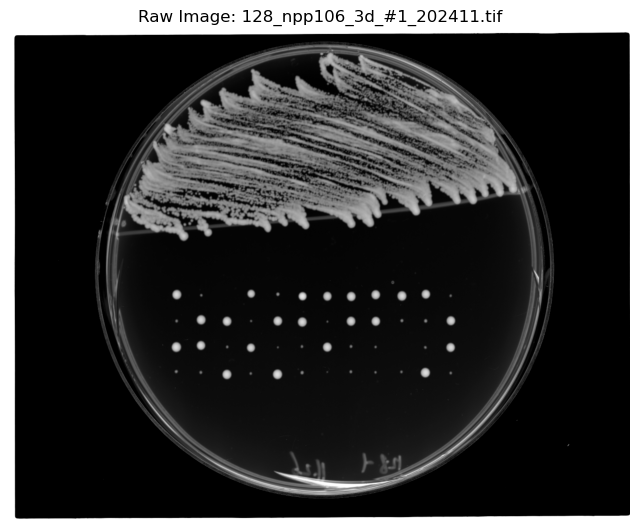

In [16]:
# TODO: Replace this with the path to your actual image
# Example: IMAGE_PATH = "../data/tetrad/example_plate.tif"
# For this tutorial, we will try to find an image in the workspace or create a dummy one if none exists.

import os

# Search for an image in the workspace to use as default
possible_images = list(Path("../").rglob("*.tif")) + list(Path("../").rglob("*.jpg"))
if possible_images:
    IMAGE_PATH = str(possible_images[0])
    print(f"Found image: {IMAGE_PATH}")
else:
    print("No images found in workspace. Please set IMAGE_PATH manually.")
    IMAGE_PATH = "path/to/your/image.tif" 

IMAGE_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/processed_data/DIT_HAP_deletion/10th_round/3d/128_npp106_3d_#1_202411.tif"

try:
    # Load the image
    raw_image = io.imread(IMAGE_PATH)
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(raw_image)
    plt.title(f"Raw Image: {Path(IMAGE_PATH).name}")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Could not load image: {e}")
    # Create a dummy image for demonstration if loading fails
    print("Creating a dummy synthetic image for demonstration...")
    from skimage.draw import disk
    raw_image = np.zeros((1200, 1200, 3), dtype=np.uint8)
    # Draw a plate circle
    rr, cc = disk((600, 600), 480)
    raw_image[rr, cc] = (200, 200, 200) # Light gray plate
    # Draw some colonies
    for r, c in [(500, 500), (550, 650), (700, 550), (600, 600)]:
        rr_c, cc_c = disk((r, c), 15)
        raw_image[rr_c, cc_c] = (50, 50, 50) # Dark colonies
    
    plt.figure(figsize=(8, 8))
    plt.imshow(raw_image)
    plt.title("Synthetic Dummy Image")
    plt.axis('off')
    plt.show()

## Step 1: Plate Detection with Hough Transform

We use the Circular Hough Transform to find the plate.
In `skimage`, this involves:
1. Converting to grayscale.
2. Detecting edges (Canny edge detector).
3. Applying the Hough Transform.
4. Finding peaks in the Hough accumulator.


Detected Plate: Center=(714, 551), Radius=520


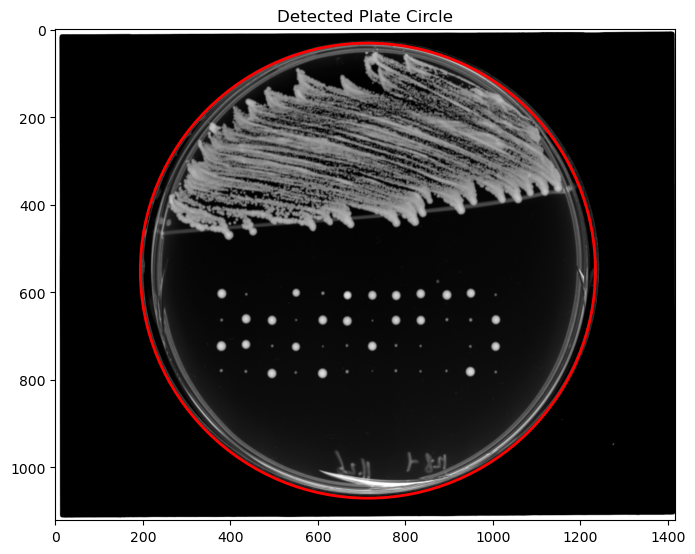

In [17]:
def detect_plate_circle(image, min_radius=400, max_radius=600):
    # 1. Convert to grayscale
    if image.ndim == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
        
    # 2. Detect edges using Canny
    # Sigma controls the amount of smoothing. Adjust if edges are too noisy or too faint.
    edges = feature.canny(gray_image, sigma=3)
    
    # 3. Detect circles using Hough Transform
    # We define a range of radii to search for
    hough_radii = np.arange(min_radius, max_radius, 10)
    hough_res = transform.hough_circle(edges, hough_radii)
    
    # 4. Select the most prominent circle
    # We look for 1 peak (total_num_peaks=1)
    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,
                                                         total_num_peaks=1)
    
    if len(cx) > 0:
        return int(cx[0]), int(cy[0]), int(radii[0])
    else:
        return None

# Run detection
center_x, center_y, radius = detect_plate_circle(raw_image, min_radius=400, max_radius=600)

print(f"Detected Plate: Center=({center_x}, {center_y}), Radius={radius}")

# Visualize detection
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
if raw_image.ndim == 3:
    image_gray = color.rgb2gray(raw_image)
else:
    image_gray = raw_image
    
ax.imshow(image_gray)
circle = plt.Circle((center_x, center_y), radius, color='r', fill=False, linewidth=2)
ax.add_patch(circle)
ax.set_title('Detected Plate Circle')
plt.show()

## Step 2: Cropping the Plate

Now that we have the center and radius, we crop the image to isolate the plate.


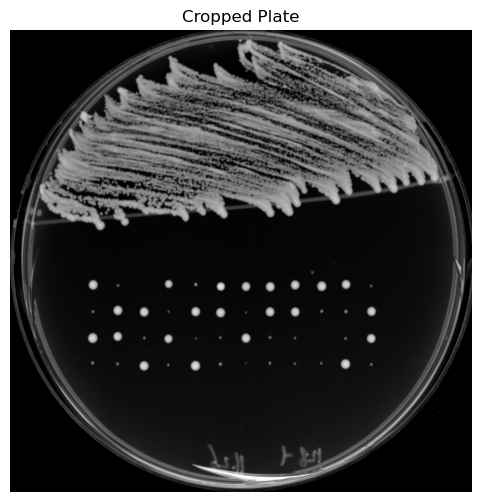

In [18]:
def crop_plate(image, center_x, center_y, radius):
    h, w = image.shape[:2]
    
    # Calculate crop coordinates
    x1 = max(0, center_x - radius)
    x2 = min(w, center_x + radius)
    y1 = max(0, center_y - radius)
    y2 = min(h, center_y + radius)
    
    cropped = image[y1:y2, x1:x2]
    return cropped

plate_image = crop_plate(raw_image, center_x, center_y, radius)

plt.figure(figsize=(6, 6))
plt.imshow(plate_image)
plt.title("Cropped Plate")
plt.axis('off')
plt.show()

## Step 3: Image Preprocessing (Contrast & Denoising)

To detect colonies, we need to enhance the image contrast and reduce noise.
1. **Grayscale Conversion**: Work on intensity values.
2. **CLAHE**: Contrast Limited Adaptive Histogram Equalization enhances local contrast.
3. **Gaussian Blur**: Smooths out high-frequency noise.


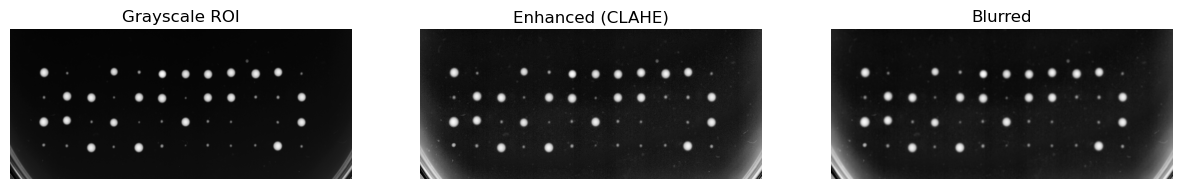

In [19]:
# 1. Convert to grayscale
if plate_image.ndim == 3:
    plate_gray = color.rgb2gray(plate_image)
else:
    plate_gray = plate_image

# Focus on the central area where colonies are expected (based on config)
h, w = plate_gray.shape
start_h = int(h * config.height_range[0] / 100)
end_h = int(h * config.height_range[1] / 100)
start_w = int(w * config.width_range[0] / 100)
end_w = int(w * config.width_range[1] / 100)

roi_gray = plate_gray[start_h:end_h, start_w:end_w]

# 2. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
roi_enhanced = exposure.equalize_adapthist(roi_gray, clip_limit=0.03)

# 3. Apply Gaussian Blur
roi_blurred = filters.gaussian(roi_enhanced, sigma=1)

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(roi_gray)
axes[0].set_title("Grayscale ROI")
axes[1].imshow(roi_enhanced)
axes[1].set_title("Enhanced (CLAHE)")
axes[2].imshow(roi_blurred)
axes[2].set_title("Blurred")
for ax in axes: ax.axis('off')
plt.show()

## Step 4: Adaptive Thresholding and Morphology

We convert the enhanced image into a binary mask (black and white) where white represents colonies.
1. **Adaptive Thresholding**: Calculates a threshold for each pixel based on its neighborhood, handling uneven lighting better than a global threshold.
2. **Morphological Opening**: Removes small noise (erosion followed by dilation).


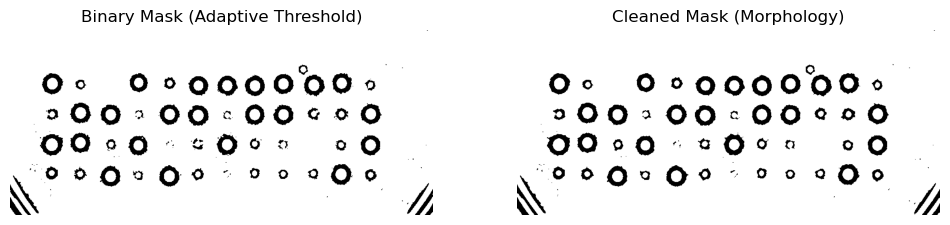

In [20]:
# 1. Adaptive Thresholding
block_size = config.adaptive_block_size
# Ensure block_size is odd
if block_size % 2 == 0: block_size += 1

local_thresh = filters.threshold_local(roi_blurred, block_size, offset=0.02) # offset adjusts sensitivity
binary_mask = roi_blurred > local_thresh

# 2. Morphological Opening (remove small noise)
# We use a disk-shaped structuring element
selem = morphology.disk(3)
binary_cleaned = morphology.binary_opening(binary_mask, selem)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary_mask)
axes[0].set_title("Binary Mask (Adaptive Threshold)")
axes[1].imshow(binary_cleaned)
axes[1].set_title("Cleaned Mask (Morphology)")
for ax in axes: ax.axis('off')
plt.show()

## Step 5: Watershed Segmentation for Colony Separation

Colonies often touch each other. Watershed segmentation helps separate them.
1. **Distance Transform**: Calculates the distance of each foreground pixel to the nearest background pixel. The centers of colonies will have the highest values.
2. **Peak Detection**: Finds the local maxima in the distance map. These are the "seeds" or markers for the colonies.
3. **Watershed**: Floods the topographic surface (inverted distance map) from the markers to find boundaries.


Number of segments found: 118


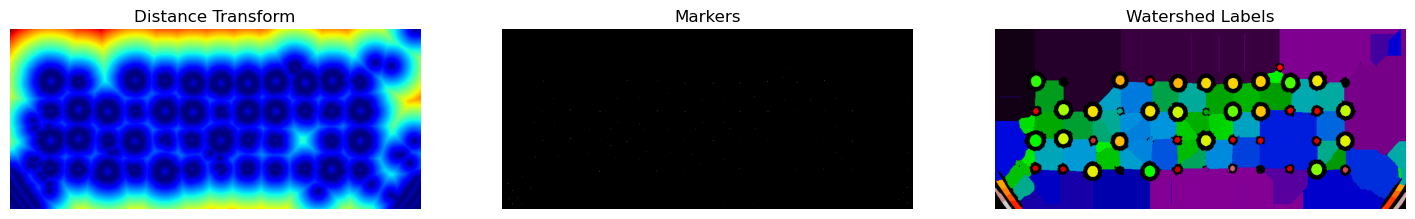

In [21]:
# 1. Distance Transform
distance = ndimage.distance_transform_edt(binary_cleaned)

# 2. Find local peaks (markers)
# min_distance ensures we don't find multiple peaks for the same colony
local_maxi = feature.peak_local_max(distance, min_distance=10, labels=binary_cleaned)

# Create markers array
markers = np.zeros_like(binary_cleaned, dtype=int)
markers[tuple(local_maxi.T)] = np.arange(1, len(local_maxi) + 1)

# 3. Watershed Segmentation
# We use -distance because watershed works on basins (minima), so we invert the peaks
labels = segmentation.watershed(-distance, markers, mask=binary_cleaned)

print(f"Number of segments found: {labels.max()}")

# Display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(distance, cmap='jet')
axes[0].set_title("Distance Transform")
axes[1].imshow(markers, cmap='nipy_spectral')
axes[1].set_title("Markers")
axes[2].imshow(labels, cmap='nipy_spectral')
axes[2].set_title("Watershed Labels")
for ax in axes: ax.axis('off')
plt.show()

## Step 6: Colony Analysis and Centroid Calculation

Now we analyze each labeled region to filter out noise and find the true colonies.
We use `measure.regionprops_table` to get properties like Area, Centroid, and Eccentricity (circularity).


Valid colonies after filtering: 105
Cluster Centroid (ROI coordinates): x=384.87, y=209.24
Cluster Centroid (Plate coordinates): x=488.87, y=677.24


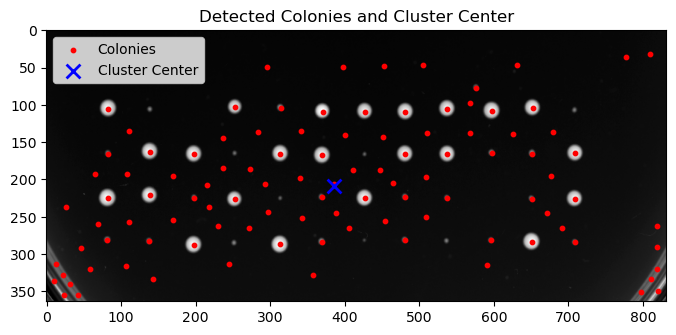

In [22]:
# Extract properties
props = measure.regionprops_table(labels, properties=('label', 'area', 'centroid', 'eccentricity'))
df = pd.DataFrame(props)

# Filter regions
# We filter based on area (too small/large) and eccentricity (too elongated)
# Note: eccentricity of 0 is a circle, 1 is a line.
valid_colonies = df[
    (df['area'] >= config.min_colony_size) & 
    (df['area'] <= 7000)
    # & (df['eccentricity'] < config.circularity_threshold) # Optional: filter by shape
].copy()

print(f"Valid colonies after filtering: {len(valid_colonies)}")

# Calculate the mean centroid of the cluster
if not valid_colonies.empty:
    # Note: regionprops returns (row, col) which corresponds to (y, x)
    avg_y = valid_colonies['centroid-0'].mean()
    avg_x = valid_colonies['centroid-1'].mean()
else:
    # Fallback to center of ROI
    avg_y, avg_x = roi_gray.shape[0] // 2, roi_gray.shape[1] // 2

print(f"Cluster Centroid (ROI coordinates): x={avg_x:.2f}, y={avg_y:.2f}")

# Map back to original plate coordinates
# Remember we cropped the ROI earlier using start_h, start_w
final_centroid_x = avg_x + start_w
final_centroid_y = avg_y + start_h

print(f"Cluster Centroid (Plate coordinates): x={final_centroid_x:.2f}, y={final_centroid_y:.2f}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_gray)
ax.scatter(valid_colonies['centroid-1'], valid_colonies['centroid-0'], c='red', s=10, label='Colonies')
ax.scatter([avg_x], [avg_y], c='blue', marker='x', s=100, linewidth=2, label='Cluster Center')
ax.legend()
ax.set_title("Detected Colonies and Cluster Center")
plt.show()

## Step 7: Final ROI Extraction

Finally, we crop the original plate image around the calculated cluster centroid to get the standardized output.


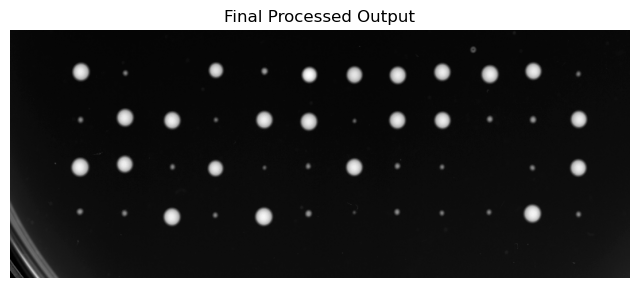

In [23]:
def crop_final_roi(image, center_x, center_y, config):
    h, w = image.shape[:2]
    
    final_width = int(w * (config.final_width_percent / 100))
    final_height = int(h * (config.final_height_percent / 100))
    
    x1 = int(max(0, center_x - final_width // 2))
    x2 = int(min(w, x1 + final_width))
    y1 = int(max(0, center_y - final_height // 2))
    y2 = int(min(h, y1 + final_height))
    
    return image[y1:y2, x1:x2]

final_result = crop_final_roi(plate_image, final_centroid_x, final_centroid_y, config)

plt.figure(figsize=(8, 6))
plt.imshow(final_result)
plt.title("Final Processed Output")
plt.axis('off')
plt.show()

## Summary: Complete Pipeline Function

Here is the complete pipeline wrapped in a single function for easy reuse.


Running full pipeline...


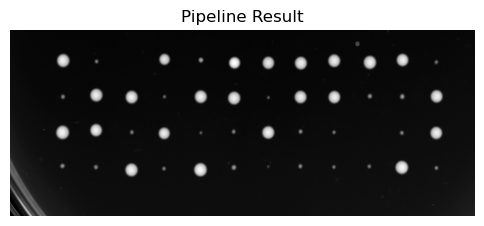

In [24]:
def process_cropped_plate(plate_img, config):
    """
    Process a cropped plate image to extract the final ROI.
    This function encapsulates Steps 3 to 7.
    """
    # 3. Preprocess
    if plate_img.ndim == 3:
        gray = color.rgb2gray(plate_img)
    else:
        gray = plate_img
        
    h, w = gray.shape
    start_h = int(h * config.height_range[0] / 100)
    end_h = int(h * config.height_range[1] / 100)
    start_w = int(w * config.width_range[0] / 100)
    end_w = int(w * config.width_range[1] / 100)
    
    roi = gray[start_h:end_h, start_w:end_w]
    
    enhanced = exposure.equalize_adapthist(roi, clip_limit=0.03)
    blurred = filters.gaussian(enhanced, sigma=1)
    
    # 4. Threshold & Morph
    block_size = config.adaptive_block_size if config.adaptive_block_size % 2 != 0 else config.adaptive_block_size + 1
    thresh = filters.threshold_local(blurred, block_size, offset=0.02)
    binary = blurred > thresh
    cleaned = morphology.binary_opening(binary, morphology.disk(3))
    
    # 5. Watershed
    distance = ndimage.distance_transform_edt(cleaned)
    local_maxi = feature.peak_local_max(distance, min_distance=10, labels=cleaned)
    markers = np.zeros_like(cleaned, dtype=int)
    markers[tuple(local_maxi.T)] = np.arange(1, len(local_maxi) + 1)
    labels = segmentation.watershed(-distance, markers, mask=cleaned)
    
    # 6. Analysis
    props = pd.DataFrame(measure.regionprops_table(labels, properties=('label', 'area', 'centroid')))
    valid = props[(props['area'] >= config.min_colony_size) & (props['area'] <= 7000)]
    
    if not valid.empty:
        avg_y = valid['centroid-0'].mean()
        avg_x = valid['centroid-1'].mean()
    else:
        avg_y, avg_x = roi.shape[0] // 2, roi.shape[1] // 2
        
    final_cx = avg_x + start_w
    final_cy = avg_y + start_h
    
    # 7. Final Crop
    result = crop_final_roi(plate_img, final_cx, final_cy, config)
    return result

def process_single_image(image_path, config):
    """
    Full pipeline to process a single yeast plate image.
    """
    # Load
    try:
        image = io.imread(image_path)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

    # 1. Detect Plate
    cx, cy, radius = detect_plate_circle(image, min_radius=400, max_radius=600)
    if cx is None:
        print("No plate detected.")
        return None
        
    # 2. Crop Plate
    plate_img = crop_plate(image, cx, cy, radius)
    
    # 3-7. Process Cropped Plate
    return process_cropped_plate(plate_img, config)

# Test the pipeline
print("Running full pipeline...")
final_output = process_single_image(IMAGE_PATH, config)

if final_output is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(final_output)
    plt.title("Pipeline Result")
    plt.axis('off')
    plt.show()
else:
    print("Pipeline failed.")

## Handling Replica Images (Multiple Plates)

Replica images typically contain 5 plates arranged in a specific order. We need to:
1. Detect all 5 plates in the large image.
2. Sort them to identify which plate corresponds to which medium (YES, HYG, NAT, LEU, ADE).
3. Process each plate individually.


In [26]:
REPLICA_PLATES_ORDER = {
    0: "YES",
    1: "HYG",
    2: "NAT",
    3: "LEU",
    4: "ADE"
}

def detect_replica_plates(image, min_radius=400, max_radius=600):
    """
    Detect multiple plates in a replica image.
    """
    if image.ndim == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
        
    # Detect edges
    edges = feature.canny(gray_image, sigma=3)
    
    # Hough Transform
    hough_radii = np.arange(min_radius, max_radius, 10)
    hough_res = transform.hough_circle(edges, hough_radii)
    
    # Find peaks
    # We ask for up to 8 peaks to be safe, then filter.
    # min_xdistance and min_ydistance prevent detecting the same circle multiple times.
    accums, cx, cy, radii = transform.hough_circle_peaks(
        hough_res, hough_radii,
        total_num_peaks=8,
        min_xdistance=min_radius,
        min_ydistance=min_radius
    )
    
    detected_plates = []
    for x, y, r in zip(cx, cy, radii):
        detected_plates.append((x, y, r))
        
    # Sort plates: Top-to-bottom (y), then Left-to-right (x)
    # We bin the Y coordinate by 1000 pixels to group plates into rows.
    # This assumes plates in the same row are within ~1000px vertical distance of each other.
    detected_plates.sort(key=lambda p: (int(round(p[1]/1000)), int(round(p[0]/600))))
    
    return detected_plates

def process_replica_image(image_path, config):
    """
    Process a replica image containing multiple plates.
    """
    try:
        image = io.imread(image_path)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return {}
        
    # Detect plates
    plates = detect_replica_plates(image, min_radius=400, max_radius=600)
    print(f"Detected {len(plates)} plates.")
    
    results = {}
    
    # Process based on count
    if len(plates) == 5:
        for idx, (cx, cy, r) in enumerate(plates):
            plate_name = REPLICA_PLATES_ORDER.get(idx, f"Plate_{idx}")
            print(f"Processing {plate_name} at ({cx}, {cy})")
            
            plate_img = crop_plate(image, cx, cy, r)
            processed = process_cropped_plate(plate_img, config)
            results[plate_name] = processed
    else:
        print(f"Warning: Expected 5 plates, found {len(plates)}. Processing all as unknown.")
        for idx, (cx, cy, r) in enumerate(plates):
            plate_name = f"Unknown_{idx}"
            plate_img = crop_plate(image, cx, cy, r)
            processed = process_cropped_plate(plate_img, config)
            results[plate_name] = processed
            
    return results

Creating synthetic replica image...


Detected 7 plates.


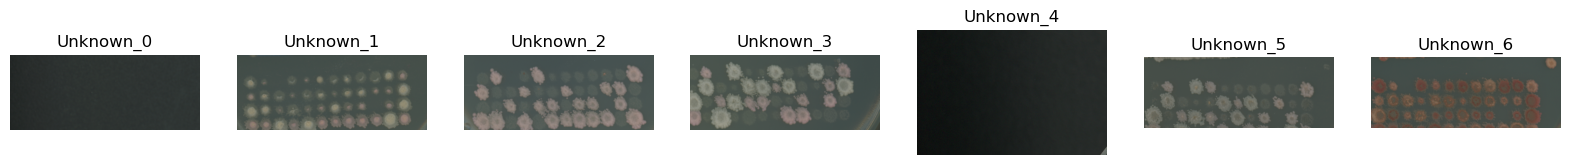

In [28]:
# Create a synthetic replica image for demonstration
print("Creating synthetic replica image...")
from skimage.draw import disk

# Create a large canvas
replica_path = "/hugedata/YushengYang/DIT_HAP_verification/data/processed_data/DIT_HAP_deletion/10th_round/replica/128_npp106_YHZAY2A_#1_202411.tif"

# Run the replica pipeline
replica_results = process_replica_image(replica_path, config)

# Display results
if replica_results:
    fig, axes = plt.subplots(1, len(replica_results), figsize=(20, 4))
    if len(replica_results) == 1: axes = [axes]
    
    for ax, (name, img) in zip(axes, replica_results.items()):
        ax.imshow(img)
        ax.set_title(name)
        ax.axis('off')
    plt.show()
else:
    print("No results to display.")

# Clean up
os.remove(replica_path)